# CBAM

CBAM은 channel attention과 spatial attention 을 구한다.

앞선 SENet은 channel만 고려했다면, 이 논문은 둘 다 고려한다.

![1](1.PNG)



## channel attention module

![2](2.PNG)

SENet은 AvgPool만 진행하였지만, 여기서는 MaxPool, AvgPool 둘 다 한다. 가운데 MLP는 SENet의 Excitation 이라고 보면 된다.

reduction ratio r 만큼 줄여주고, 다시 키워준다.

그리고 나온 결과 두 개를 서로 더하고 sigmoid를 해준다.



## spatial attetion module

![3](3.PNG)

channel attention 이랑 비슷하다. 여기서는 어느 위치가 중요한 부분인지 학습하는 것이 핵심이다.

![4](4.PNG)

결과물을 concat 한 다음, 7x7 filter를 이용하여 conv 연산을 해준다.

CBAM도 SENet 처럼 어떤 모델이든 결합할 수 있다. 논문 저자들은 resnet50에 결합하였고, r은 16으로 설정하였다.









In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output




In [76]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, r=16):
        super().__init__()

        self.channels = channels
        self.mlp = nn.Sequential(
            nn.Linear(self.channels, self.channels//r),
            nn.ReLU(),
            nn.Linear(self.channels//r, self.channels)
        )
    
    def forward(self, x):
        maxpool_out = F.adaptive_max_pool2d(x,(1,1))
        avgpool_out = F.adaptive_avg_pool2d(x,(1,1))

        avgpool_out = self.mlp(avgpool_out.view(x.size(0),-1))
        maxpool_out = self.mlp(maxpool_out.view(x.size(0),-1))

        out = F.sigmoid(avgpool_out + maxpool_out)

        return x*out.unsqueeze(-1).unsqueeze(-1)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=2,out_channels=1, kernel_size=7,stride=1,padding=(7-1)//2),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        b, c, h, w = x.size()
        maxpool_out = F.adaptive_max_pool1d(x.view(b, c, h*w).permute(0,2,1),1)
        maxpool_out = maxpool_out.permute(0,2,1)
        maxpool_out = maxpool_out.view(b,1,h,w)

        avgpool_out = F.adaptive_avg_pool1d(x.view(b, c, h*w).permute(0,2,1),1)
        avgpool_out = avgpool_out.permute(0,2,1)
        avgpool_out = avgpool_out.view(b,1,h,w)

        out = torch.cat((avgpool_out,maxpool_out), 1)

        out = self.conv(out)

        return x*out

        


class CBAM(nn.Module):
    def __init__(self, channels,r=16):
        super().__init__()
        self.r = r
        self.channels = channels
        self.channel_attention = ChannelAttention(self.channels,r)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        out = self.channel_attention(x)
        out = self.spatial_attention(out)

        return out


In [77]:
class CBAMBasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels,stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.CBAM = CBAM(out_channels, 16)

    self.downsample = nn.Sequential()

    # 더하기 위해서는 모양을 맞추줘야 됨.
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.CBAM(out)
    out += self.downsample(x)
    out = F.relu(out)
      
    return out
  
  

        

In [78]:
class ResNet34(nn.Module):
  def __init__(self, block, num_blocks= [3,4,6,3], num_classes = 10):
    super().__init__()
    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.conv2_x = self._make_layer(block, 64, num_blocks[0], 1)
    self.conv3_x = self._make_layer(block, 128, num_blocks[1], 2)
    self.conv4_x = self._make_layer(block, 256, num_blocks[2], 2)
    self.conv5_x = self._make_layer(block, 512, num_blocks[3], 2)
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, num_classes)

  
  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks -1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    
    return nn.Sequential(*layers)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2_x(out)
    out = self.conv3_x(out)
    out = self.conv4_x(out)
    out = self.conv5_x(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)

    return out

In [79]:
def plot(epochs, train_losses, train_accs, test_losses, test_accs):
  clear_output()
  plt.figure(figsize = (20,5))
  plt.title('epoch {0}'.format(epochs[-1]))
  plt.subplot(221)
  plt.title('train_accuracy')
  plt.plot(train_accs)
  plt.subplot(222)
  plt.title('train_loss')
  plt.plot(train_losses)
  plt.subplot(223)
  plt.title('test_accuracy')
  plt.plot(test_accs)
  plt.subplot(224)
  plt.title('test_losses')
  plt.plot(test_losses)
  plt.tight_layout()
  plt.show()


def fit(model, epochs, device, optimizer, criterion, train_loader, test_loader):
  epoch_range = []
  
  train_losses = []
  test_losses = []

  train_accs = []
  test_accs = []
  i = 1

  model.to(device)
  for epoch in range(epochs):


    train_loss = 0.
    train_acc = 0.

    model.train()
    for data, target in train_loader:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()

      acc = (output.argmax(dim=1) == target).float().mean()
      train_loss += loss
      train_acc += acc

      optimizer.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)


    test_loss, test_acc = 0., 0.

    model.eval()
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)

      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        acc = (output.argmax(dim=1)==target).float().mean()
        
        test_loss += loss
        test_acc += acc

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    epoch_range.append(i)
    
      
    i += 1
        
    plot(epoch_range, train_losses, train_accs, test_losses, test_accs)
    print('epoch {0}'.format(i))
    print('train_acc : {0}'.format(train_acc))
    print('train_loss : {0}'.format(train_loss))
    print('test_acc : {0}'.format(test_acc))
    print('test_loss : {0}'.format(test_loss))


def run(model):
  NUM_EPOCHS = 10
  BATCH_SIZE =64
  LR = 0.01

  train_transform = transforms.Compose([
        transforms.Resize(24),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
  ])


  test_transform = transforms.Compose([
                                      transforms.Resize(24),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
  ])

  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

  optimizer = optim.Adam(params=model.parameters(), lr=LR)

  criterion = nn.CrossEntropyLoss()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  fit(model, NUM_EPOCHS, device, optimizer, criterion, train_loader, test_loader)


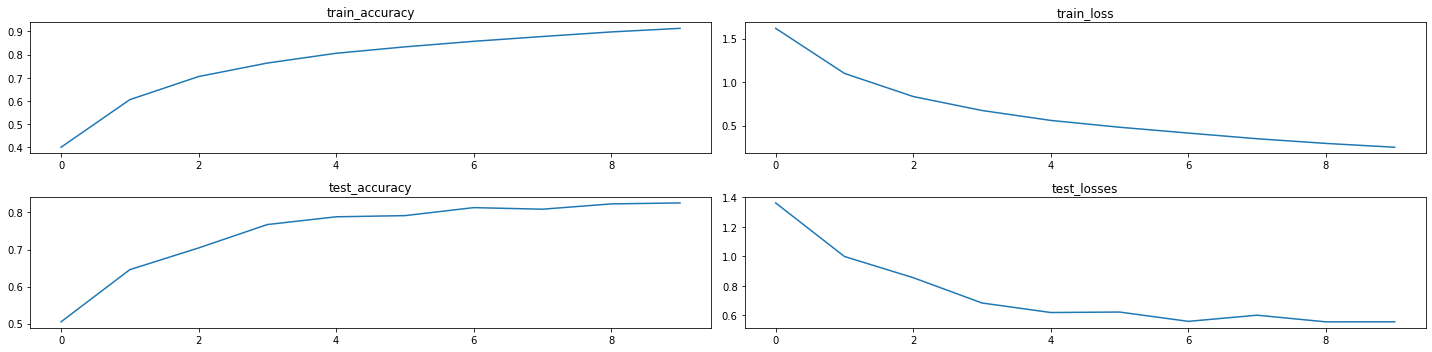

epoch 11
train_acc : 0.9130234718322754
train_loss : 0.2500911056995392
test_acc : 0.8257364630699158
test_loss : 0.5553040504455566


In [80]:
model = ResNet34(CBAMBasicBlock)
run(model)